In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mplhep as hep
hep.style.use("CMS")


df = pd.read_parquet(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\merged_nominal.parquet')

with open(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\summary.json', "r") as f:
  proc_dict = json.load(f)["sample_id_map"]
  
  
sig = df[df.process_id == proc_dict["GluGluToRadionToHHTo2G2Tau_M-1000"]] # just one signal process, mass of X is 1000 GeV
sig['Classification']=np.ones(sig['Diphoton_mass'].size)
#bkg = df[df.process_id == proc_dict["DiPhoton"]] # just one of the background processes

C:\Users\drpla\AppData\Local\Temp\ipykernel_18380\1386577896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['Classification']=np.ones(sig['Diphoton_mass'].size)


In [3]:
"""Concatenating the background data"""
background_list=['Data','DiPhoton', 'TTGG', 'TTGamma',#list of each bkgs for concatenation
 'TTJets',
 'VBFH_M125',
 'VH_M125',
 'WGamma',
 'ZGamma',
 'ggH_M125', 
 'ttH_M125',
 'GJets']

listforconc=[]
for i in background_list:                               #creating a concatenated list of bkg
    bkgg = df[df.process_id == proc_dict[i]]
    listforconc.append(bkgg)
    
background = pd.concat(listforconc)
background['Classification']=np.zeros(background['Diphoton_mass'].size)

In [4]:
MinusNineBinning=['ditau_met_dPhi',
                  'ditau_deta',
                  'ditau_dR',
                  'ditau_dphi',
                  'ditau_pt',
                  'Diphoton_ditau_dphi',
                  'dilep_leadpho_mass',
                  'reco_MX_mgg',
                  'Diphoton_ditau_deta',
                  'Diphoton_sublead_lepton_deta',
                  'Diphoton_sublead_lepton_dR',
                  'LeadPhoton_ditau_dR']


In [5]:
"""Concatenating Signal and Background"""
"""Choosing Best Features given the M=1000 AUC scores"""
FullSignalBackground=pd.concat([sig,background])

df_TopFeatures=pd.DataFrame()
TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','weight_central','Classification']
for feature in TopFeatures:
    df_TopFeatures[feature]=FullSignalBackground[feature]
    

"""want to remove the -9 bins from columns in dataframe that have those
for each column, if the column is in 
"""   
#for columns in df_TopFeatures.columns:
#    if columns in MinusNineBinning:
#        df_TopFeatures.loc[df_TopFeatures[columns] < -8, columns] = 0



features = df_TopFeatures.drop(columns=['Classification'])  # Extracting features
labels = df_TopFeatures['Classification']  # Extracting labels

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
test_weights=pd.DataFrame()
train_weights=pd.DataFrame()
train_weights['weight_central']=train_features['weight_central']
test_weights['weight_central']=test_features['weight_central']

train_features=train_features.drop(columns=['weight_central'])
test_features=test_features.drop(columns=['weight_central'])

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)


In [49]:
class SimpleNN(nn.Module):
#     def __init__(self,input,hidden,output):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(input,hidden)  # Input layer to hidden layer
#         self.relu1 = nn.ReLU()  # Activation function
#         self.fc2 = nn.Linear(hidden, output)  # Hidden layer to output layer
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = torch.sigmoid(x)
#         return x
    
    
    def __init__(self):
        super(SimpleNN,self).__init__()
        self.hidden1 = nn.Linear(10, 20)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(20, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.act2(x)
        x = self.hidden2(x)
        x = self.output(x)
        x = self.act_output(x)

        return x


    def weightedBCELoss(self, input, target, weight):
      x, y, w = input, target, weight
      log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
      #return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))
      return -w * (y*log(x) + (1-y)*log(1-x))
    
    def batch_weightedBCELoss(self, input, target, weight, batch_size):
#batch_weightedBCELoss(self, train, train_labels_tensor, train_weights_tensor, batch_size)
        self.batch_size=batch_size

        target=target.unsqueeze(1)
        
        
       # train=model.forward(input)

        total_batch_err=torch.empty(0,1)
        output_length=input.shape[0]
        batch_remainder=output_length%batch_size

        for i in range(0, output_length//batch_size):
            weights = weight[i*(batch_size):(i+1)*(batch_size), :]
            labels = target[i*(batch_size):(i+1)*(batch_size), :]
            inputs = input[i*(batch_size):(i+1)*(batch_size), :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            total_batch_err=torch.cat((total_batch_err,loss)) 
        #    print(total_batch_err.shape[0])

        if batch_remainder > 0:
            weights = weight[(output_length//batch_size)*batch_size:, :]
            labels = target[(output_length//batch_size)*batch_size:, :]
            inputs = input[(output_length//batch_size)*batch_size:, :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            #weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
            total_batch_err=torch.cat((total_batch_err,loss))
        #    print(total_batch_err.shape[0])
            
        return torch.mean(total_batch_err)


In [50]:
model = SimpleNN()

In [51]:
trained=model.forward(train_features_tensor)

In [52]:
#model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)

For Epoch 1: Loss = 0.053592681884765625
For Epoch 2: Loss = 0.04446583241224289
For Epoch 3: Loss = 0.036722488701343536
For Epoch 4: Loss = 0.030251672491431236
For Epoch 5: Loss = 0.02491956576704979
For Epoch 6: Loss = 0.020577581599354744
For Epoch 7: Loss = 0.01707335002720356
For Epoch 8: Loss = 0.014261231757700443
For Epoch 9: Loss = 0.01200862880796194
For Epoch 10: Loss = 0.010201608762145042
For Epoch 11: Loss = 0.008747079409658909
For Epoch 12: Loss = 0.007570527493953705
For Epoch 13: Loss = 0.006613573990762234
For Epoch 14: Loss = 0.005830537062138319
For Epoch 15: Loss = 0.0051857419312000275
For Epoch 16: Loss = 0.004651492461562157
For Epoch 17: Loss = 0.004206014331430197
For Epoch 18: Loss = 0.003832243848592043
For Epoch 19: Loss = 0.003516708966344595
For Epoch 20: Loss = 0.0032487218268215656


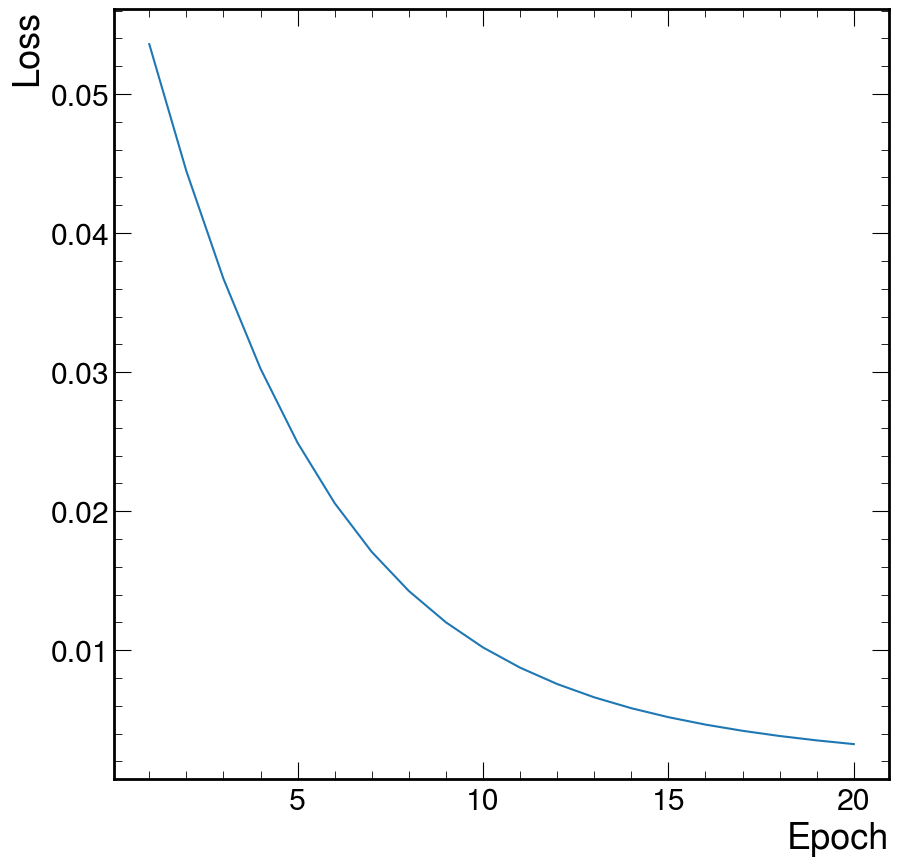

In [53]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossdata=[]
epochs=20
epochlist=[]
for i in range(0,20):
    epochlist.append(i+1)
for i in range(0,epochs):
    trained=model.forward(train_features_tensor)
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'For Epoch {i+1}: Loss = {loss}')
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

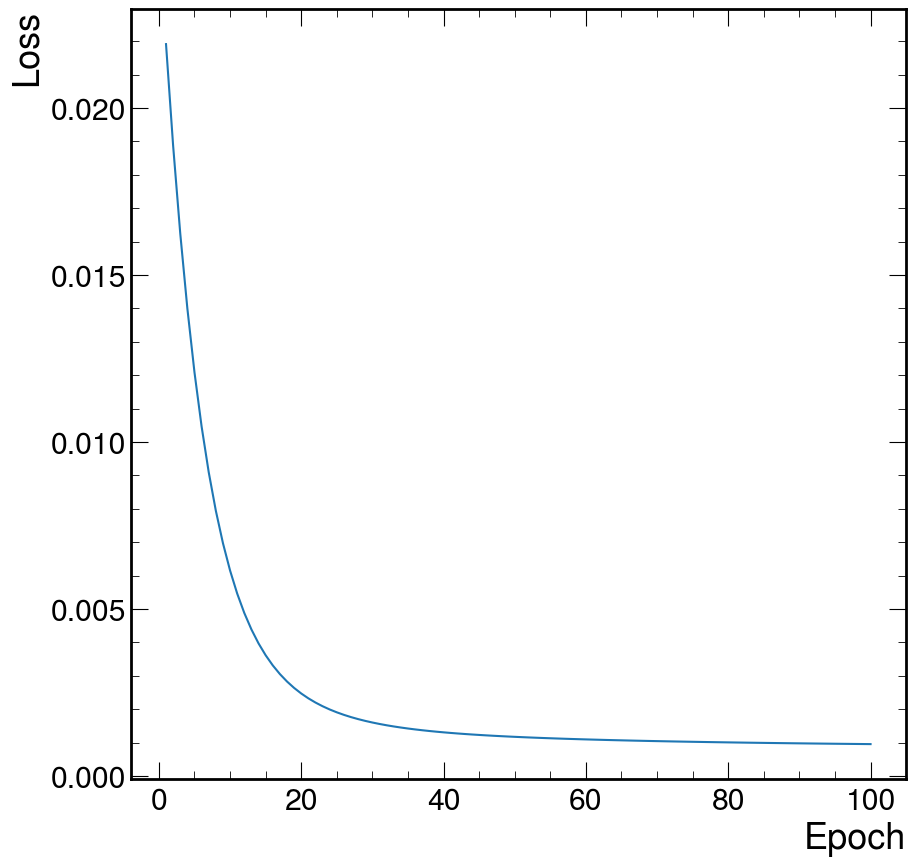

In [27]:
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

(array([3.66945e+05, 9.07640e+04, 7.09060e+04, 5.32060e+04, 3.83540e+04,
        2.43980e+04, 1.07490e+04, 6.94000e+02, 1.42000e+02, 1.19000e+02,
        9.90000e+01, 1.01000e+02, 7.20000e+01, 6.00000e+01, 6.20000e+01,
        6.70000e+01, 5.60000e+01, 5.00000e+01, 4.80000e+01, 3.60000e+01,
        3.90000e+01, 3.70000e+01, 3.10000e+01, 3.10000e+01, 2.90000e+01,
        2.80000e+01, 3.10000e+01, 2.90000e+01, 2.70000e+01, 3.60000e+01,
        3.90000e+01, 2.40000e+01, 2.70000e+01, 2.70000e+01, 2.70000e+01,
        3.10000e+01, 2.60000e+01, 3.30000e+01, 3.00000e+01, 2.90000e+01,
        2.10000e+01, 2.50000e+01, 2.20000e+01, 3.00000e+01, 4.40000e+01,
        2.30000e+01, 2.20000e+01, 2.40000e+01, 2.20000e+01, 2.00000e+01,
        3.30000e+01, 2.40000e+01, 2.50000e+01, 2.80000e+01, 2.50000e+01,
        2.00000e+01, 2.80000e+01, 2.90000e+01, 2.60000e+01, 3.20000e+01,
        2.50000e+01, 2.90000e+01, 3.20000e+01, 2.30000e+01, 2.70000e+01,
        2.00000e+01, 2.00000e+01, 1.90000e+01, 2.00

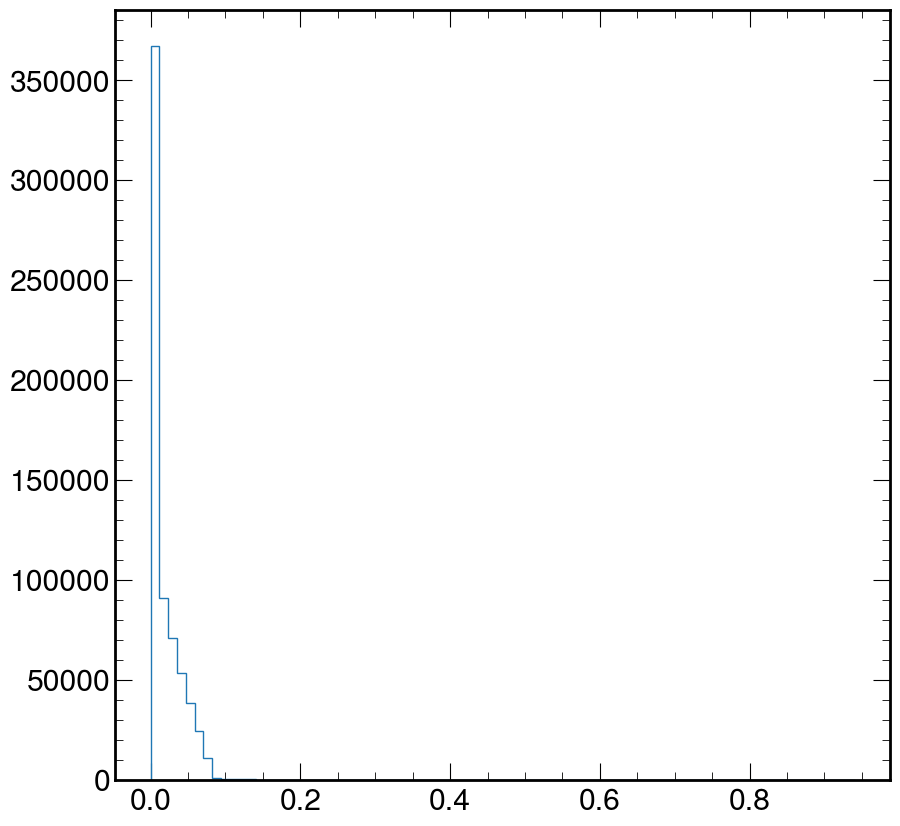

In [54]:
plt.hist(trained.squeeze().tolist(),bins=80,label='predicted',histtype="step")
#plt.hist(train_labels_tensor.tolist(),bins=80,label='output',histtype="step")


In [169]:
trained


tensor([[0.1543],
        [0.0306],
        [0.0242],
        ...,
        [0.4463],
        [0.1518],
        [0.1038]], grad_fn=<SigmoidBackward0>)

In [154]:
data = trained.squeeze().tolist()  # Replace with your dataset

chunk_size = 1000  # Define the chunk size

# Process data in chunks
for i in range(0, len(data), chunk_size):
    chunk = data[i:i+chunk_size]  # Get a chunk of data
   # print('Processed Chunk', len(chunk))  # Process the chunk
HELPPPPPP


NameError: name 'HELPPPPPP' is not defined

In [156]:
error = weightedBCELoss(trained, train_labels_tensor, train_weights_tensor)

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1555188573184 bytes.

In [212]:
for i in range(0,size/batchsize):
    weights = train_weights_tensor[:1024, :]
    labels = train_labels_tensor.unsqueeze(1)[:1024,:]
    training = trained[:1024,:]

In [213]:
error = weightedBCELoss(training, labels, weights)
error

tensor([[ 0.0478],
        [-0.0017],
        [ 0.1328],
        ...,
        [ 0.7102],
        [-0.0230],
        [ 0.1412]], grad_fn=<MulBackward0>)

In [215]:
error.shape

torch.Size([1024, 1])

In [304]:
batch_size=1024

train=model.forward(train_features_tensor)

total_batch_err=torch.empty(0,1)
output_length=train_weights_tensor.shape[0]
batch_remainder=output_length%batch_size

for i in range(0, output_length//batch_size):
    weights = train_weights_tensor[i*(batch_size):(i+1)*(batch_size), :]
    labels = train_weights_tensor[i*(batch_size):(i+1)*(batch_size), :]
    inputs = train[i*(batch_size):(i+1)*(batch_size), :]

    loss=weightedBCELoss(inputs, labels, weights)
    
    total_batch_err=torch.cat((total_batch_err,loss)) 
    print(total_batch_err.shape[0])
    
if batch_remainder > 0:
    weights = train_weights_tensor[(output_length//batch_size)*batch_size:, :]
    labels = train_weights_tensor[(output_length//batch_size)*batch_size:, :]
    inputs = train[(output_length//batch_size)*batch_size:, :]

    loss=weightedBCELoss(inputs, labels, weights)
    
    weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
    total_batch_err=torch.cat((total_batch_err,weights))
    print(total_batch_err.shape[0])

1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936
40960
41984
43008
44032
45056
46080
47104
48128
49152
50176
51200
52224
53248
54272
55296
56320
57344
58368
59392
60416
61440
62464
63488
64512
65536
66560
67584
68608
69632
70656
71680
72704
73728
74752
75776
76800
77824
78848
79872
80896
81920
82944
83968
84992
86016
87040
88064
89088
90112
91136
92160
93184
94208
95232
96256
97280
98304
99328
100352
101376
102400
103424
104448
105472
106496
107520
108544
109568
110592
111616
112640
113664
114688
115712
116736
117760
118784
119808
120832
121856
122880
123904
124928
125952
126976
128000
129024
130048
131072
132096
133120
134144
135168
136192
137216
138240
139264
140288
141312
142336
143360
144384
145408
146432
147456
148480
149504
150528
151552
152576
153600
154624
155648
156672
157696
158720
159744
160768
161792


In [301]:
i=0
weights1 = train_weights_tensor[i*(1024):(i+1)*(1024), :]
i=1
weights2 = train_weights_tensor[i*(1024):(i+1)*(1024), :]

-944

In [298]:
1195600-1197414


-1814

In [246]:
623536-623616

-80

In [247]:
for i in range(0, train_weights_tensor.shape[0]//1024):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [248]:
607*1024

621568

In [250]:
train_features_tensor.shape

torch.Size([623536, 10])

In [251]:
623536-621568

1968

In [271]:
append=torch.empty(0,1)


In [272]:
append=torch.cat((append,weights1))

In [279]:
append.shape

torch.Size([622592, 1])

In [282]:
train_features_tensor.shape

torch.Size([623536, 10])

In [283]:
623536-622592


944

In [284]:
623536%1024

944

In [292]:
total_batch_err.shape

torch.Size([1196544, 1])